# Приоритизация гипотез и оценка результатов А/В-теста

   
<div class="alert alert-info">
<h2> Привет!<a class="tocSkip"></h2>
<hr>  
Я - Сергей. Рад что ты читаешь это текст :) Сделаю пару ремарок общего характера. В описании выполняемых действий, комментариях, я использую местоимение 'мы', так как считаю что ты, читая код, становиться моим соучастником ('соучавствующие программирование') и мы вместе проходим по пути исследования. Да и сформировлась привычка так писать в ходе написания научных работ.   
NB! - так помечаю важные на мой взгдял идеи, которые стоит взять на заметку; инсайты, проработка которых требует большего знания предметной области.   
Надеюсь мои многословные комментарии тебя не утомят.    
</div>
    
<br/>

**Оглавление**    
[1  Описание проекта](#description)     
[2  Изучение и предобработка данных](#exploration)    
[3  Приоритизация гипотез](#prioritization)  
[3.1  Фреймворк ICE для приоритизации гипотез](#ice)   
[3.2  Фреймворк RICE для приоритизации гипотез](#rice)   
[4  Анализ A/B-теста](#a_b_test)   
[4.1  График кумулятивной выручки по группам](#a_b_test_1)   
[4.2  Гафик кумулятивного среднего чека по группам](#a_b_test_2)   
[4.3  График относительного изменения кумулятивного среднего чека группы B к группе A](#a_b_test_3)   
[4.4  График кумулятивной конверсии по группам](#a_b_test_4)   
[4.5  График относительного изменения кумулятивной конверсии группы B к группе A](#a_b_test_5)   
[4.6  Точечный график количества заказов по пользователям](#a_b_test_6)   
[4.7  95-й и 99-й перцентили количества заказов на пользователя](#a_b_test_7)   
[4.8  Точечный график стоимостей заказов](#a_b_test_8)   
[4.9  95-й и 99-й перцентили стоимости заказов](#a_b_test_9)   
[4.10  Расчёт статистической значимости различий в конверсии между группами по «сырым» данным](#a_b_test_10)   
[4.11  Расчёт статистической значимости различий в среднем чеке заказа между группами по «сырым» данным](#a_b_test_11)   
[4.12  Расчёт статистической значимости различий в конверсии между группами по «очищенным» данным](#a_b_test_12)   
[4.13  Расчёт статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным](#a_b_test_13)   
[4.14  Решение по результатам теста](#a_b_test_summary)   
[5 Заключение](#summary)

## Описание проекта <a id="description"></a> 
   
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.  

**Задачи исследования**  
1. Приоритизировать гипотезы.
1. Проанализировать результаты A/B-теста и принять решение об его завершении или продолжении.   
    
**Описание данных**  
1. Файл hypothesis.csv  
Hypothesis — краткое описание гипотезы;   
Reach — охват пользователей по 10-балльной шкале;   
Impact — влияние на пользователей по 10-балльной шкале;   
Confidence — уверенность в гипотезе по 10-балльной шкале;  
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.  
1. Файл orders.csv  
transactionId — идентификатор заказа;  
visitorId — идентификатор пользователя, совершившего заказ;  
date — дата, когда был совершён заказ;  
revenue — выручка заказа;  
group — группа A/B-теста, в которую попал заказ.
1. Файл visitors.csv   
date — дата;   
group — группа A/B-теста;  
visitors — количество пользователей в указанную дату в указанной группе A/B-теста.     

---

## Изучение и предобработка данных <a id="exploration"></a>

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

In [2]:
from io import BytesIO
import requests
spreadsheet_hypothesis = '1JtjsAO-q4zWGeMq0igfUnaNvvQ9x93WprdM2bHESQ7s'
spreadsheet_orders = '1JS5tiMDWi9k867ic8yBPCFrAICQLQqD_hubmNS0-KiY'
spreadsheet_visitors = '1BbtMxPuA1Fhdnrp6ZW27GPDON1WE_1A3b359sjN0OPw'
file_name_hypothesis = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_hypothesis)
file_name_orders = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_orders)
file_name_visitors = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_visitors)
r_hypothesis = requests.get(file_name_hypothesis)
r_order = requests.get(file_name_orders)
r_visitors = requests.get(file_name_visitors)
hypothesis = pd.read_csv(BytesIO(r_hypothesis.content))
orders = pd.read_csv(BytesIO(r_order.content))
visitors = pd.read_csv(BytesIO(r_visitors.content))

Выведим данные обо всех датафремах

In [3]:
hypothesis.info()
pd.options.display.max_colwidth = 200
hypothesis.head(9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Пропущенных значений нет, всего 9 записей - гипотез. Название колонок приведм к срочноым буквам (к хорошому тону написания заголовков колонок) 

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()
#hypothesis.head(9)

In [5]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Пропущенных значений нет. Дата храниться в форматее object, изменим на datetime

In [6]:
orders['date'] = pd.to_datetime(orders['date'])
#orders.info()

In [7]:
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Пропущенных значений нет. Дата храниться в форматее object, изменим на datetime

In [8]:
visitors['date'] = pd.to_datetime(visitors['date'])
#visitors.info()

Проверим наличие дубликатов

In [9]:
# Проверям дубликаты
print(hypothesis.duplicated().sum())
print(orders.duplicated().sum())
print(visitors.duplicated().sum())

0
0
0


Дубликатов нет

---

## Приоритизация гипотез<a id="prioritization"></a>

### Фреймворк ICE для приоритизации гипотез<a id="ice"></a>

In [10]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis_ice = hypothesis[['hypothesis', 'ICE']].round(2).sort_values(by='ICE', ascending=False)
pd.options.display.max_colwidth = 200
display(hypothesis_ice)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


**Вывод** При применения фрейворка ICE наиболее приоритетными гипотезами являются:     
* Запустить акцию, дающую скидку на товар в день рождения (гипотеза 8);   
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (гипотеза 0);   
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (гипотеза 7).

### Фреймворк RICE для приоритизации гипотез<a id="rice"></a>

In [11]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
hypothesis_rice = hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)
pd.options.display.max_colwidth = 200
display(hypothesis_rice)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Вывод** При применения фрейворка RICE наиболее приоритетными гипотезами являются:   
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (гипотеза 7);  
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа (гипотеза 2);  
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (гипотеза 0).

Обьеденим оценки приоритетотов гипотез, что бы их можно было сопоставить и выделить значений от большего к меньшему цветом

In [12]:
hypothesis_ice_rice = hypothesis_ice.merge(hypothesis_rice, on = 'hypothesis')
color = sns.light_palette('blue', as_cmap=True)
pd.options.display.max_colwidth = 200
hypothesis_ice_rice.style.background_gradient(cmap=color)

,hypothesis,ICE,RICE
0,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000
1,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.330000,40.000000
2,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000
3,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000
4,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000
5,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000
6,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.330000,4.000000
7,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.120000,9.000000
8,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000


**Выводы:**   
1. Изменения приоритета гипотез связана с тем, что фремворк RICE учитывает охват - таким образом более высокий приоритет получили гипотезы которы могут обеспечить больший овхват пользователей. Гипотеза 8 - Запустить акцию, дающую скидку на товар в день рождения - в моменте охватвывает небольшую долю аудитории;   
1. Приоритет стот отдать гипотезам:   
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (гипотеза 7) и   
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (гипотеза 0) -    
так они получили высокий приорите в рамках обоих фреймворков.

---

## Анализ A/B-теста<a id="a_b_test"></a>

In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Все пользователи разделены на 2 группы: А (контрольная) и В (эксперементальная)

In [14]:
# Найдём дату начала и окончания теста
print('Дата начала теста - ', min(orders['date']))
print('дата окончания теста - ', max(orders['date']))

# Подсчитиаем общее число пользователей и чило в каждой из групп 
print('Общее число посещений - ', orders['visitorId'].count())
group_a = orders.loc[orders.loc[:, 'group'] == 'A']['visitorId'].count()
group_b = orders.loc[orders.loc[:, 'group'] == 'B']['visitorId'].count()
print('Число посещений пользователями из группы А - ' , group_a)
print('Число посещений пользователями из группы В - ', group_b)

# Подсчитиаем чиcло уникальных пользователей
print('Число уникальных пользователей - ', orders['visitorId'].nunique())
group_a_unique = orders.loc[orders.loc[:, 'group'] == 'A']['visitorId'].nunique()
group_b_unique = orders.loc[orders.loc[:, 'group'] == 'B']['visitorId'].nunique()
print('Число уникальных пользователей из группы А - ', group_a_unique)
print('Число уникальных пользователей из группы В - ', group_b_unique)
print('Сумма уникальных пользователелей из группы А и В - ', group_a_unique + group_b_unique)

Дата начала теста -  2019-08-01 00:00:00
дата окончания теста -  2019-08-31 00:00:00
Общее число посещений -  1197
Число посещений пользователями из группы А -  557
Число посещений пользователями из группы В -  640
Число уникальных пользователей -  1031
Число уникальных пользователей из группы А -  503
Число уникальных пользователей из группы В -  586
Сумма уникальных пользователелей из группы А и В -  1089


**Вывод** Сумма уникальных пользователелей из группы А и В больше общего числа уникальных пользователей - одни  и теже пользователи попали в обе группы. Создаем массив уникальных пар значений дат и групп теста и удалим пользователей попавших в обе группы.

In [15]:
orders.groupby('visitorId').agg({'group' : 'nunique'}).reset_index().query('group>1')['visitorId']

2          8300375
44       199603092
51       232979603
55       237748145
66       276558944
84       351125977
97       393266494
114      457167155
119      471551937
122      477780734
192      818047933
236      963407295
299     1230306981
311     1294878855
316     1316129916
318     1333886533
340     1404934699
386     1602967004
393     1614305549
402     1648269707
406     1668030113
422     1738359350
436     1801183820
469     1959144690
487     2038680547
491     2044997962
569     2378935119
591     2458001652
614     2579882178
619     2587333274
622     2600415354
639     2654030115
648     2686716486
661     2712142231
662     2716752286
677     2780786433
710     2927087541
715     2949041841
718     2954449915
744     3062433592
784     3202540741
792     3234906277
884     3656415546
897     3717692402
909     3766097110
917     3803269165
932     3891541246
950     3941795274
954     3951559397
957     3957174400
958     3963646447
960     3972127743
963     3984

In [16]:
datesGroups = orders[['date','group']].drop_duplicates()
print('Число уникальных пользователей - ', orders['visitorId'].nunique())

Число уникальных пользователей -  1031


Создадим таблицу ordersAggregated, содержащую следующие колонки:   
* дата;   
* группа A/B-теста;   
* число уникальных заказов в группе теста по указанную дату включительно;   
* число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;  
* суммарную выручку заказов в группе теста по указанную дату включительно.

In [17]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionId' : pd.Series.nunique,
'visitorId' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

Объявим переменную visitorsAggregated, содержащую:  
* дату;    
* группу A/B-теста;    
* количество уникальных посетителей в группе теста по указанную дату включительно.

In [18]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

Определим переменную cumulativeData, объединив ordersAggregated и visitorsAggregated по колонкам 'date', 'group' методом merge().   
Присвоим столбцам cumulativeData названия ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']



In [19]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
display(cumulativeData)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


 ### График кумулятивной выручки по группам<a id="a_b_test_1"></a>

Объявим переменные cumulativeRevenueA и cumulativeRevenueB, в которых сохраните данные о датах, выручке и числе заказов в группах A и B.


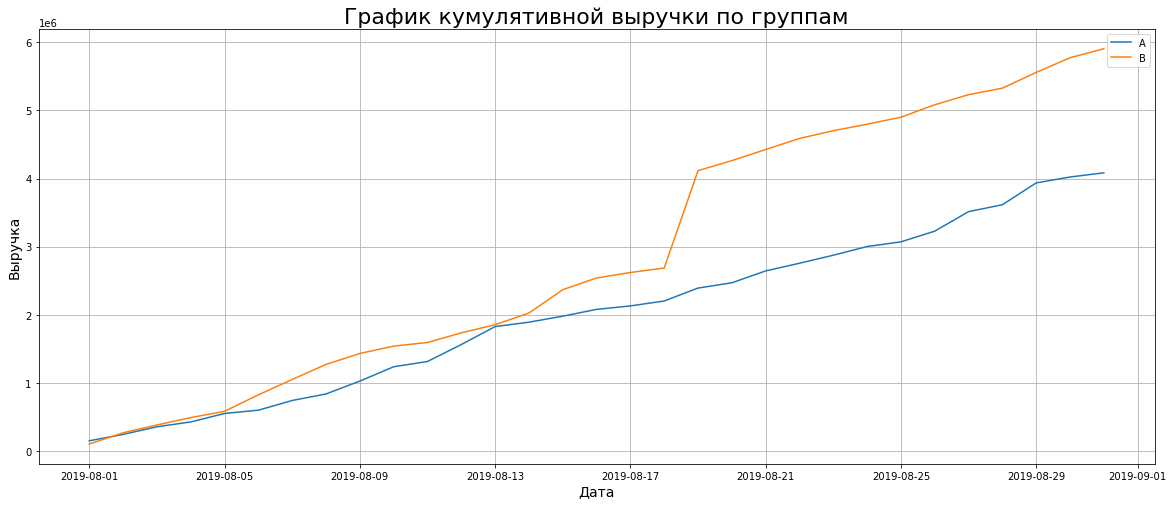

In [20]:
# Создаём датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# Создаём датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Задаем размер фигуры
plt.figure(figsize=(20,8))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки по группам', size=22)
plt.xlabel('Дата', size=14)
plt.ylabel('Выручка', size=14)
plt.legend()
plt.grid()
plt.show()

**Вывод** До 18 августа 2019 выручка почти равномерно увеличивается. После произошёл скачок вручки группы В, вследствии роста числа заказов, либо появление небольшого числа очень дорогих заказов.

### Гафик кумулятивного среднего чека по группам<a id="a_b_test_2"></a>

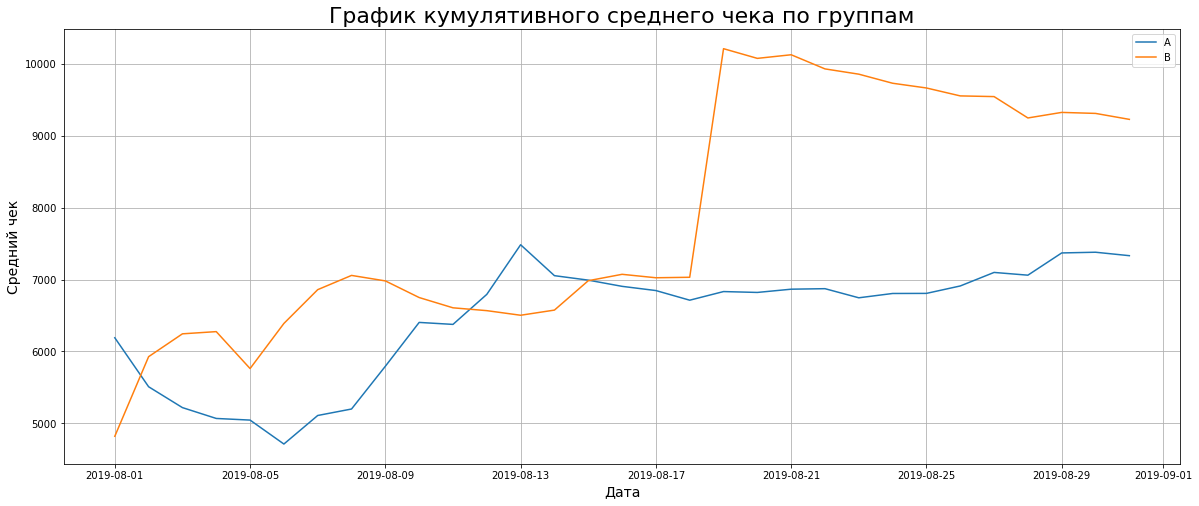

In [21]:
plt.figure(figsize=(20,8))

# Расичитываем кумулятивныё средний чек по группам
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')


plt.legend()
plt.title('График кумулятивного среднего чека по группам', size=22)
plt.xlabel('Дата', size=14)
plt.ylabel('Средний чек', size=14)
plt.legend()
plt.grid()
plt.show()

**Вывод** Средний чек у обоих групп выравнивается к 18 августа 2019. Далее после резкого скачка у группы В наблюдаем стабильное уменьшение среднего чека - вдимо всё таки оказали вляние крупные заказы. Чтобы группа вернулась к реальному среднему чеку нужен больший горизонт событий.

### График относительного изменения кумулятивного среднего чека группы B к группе A<a id="a_b_test_3"></a>

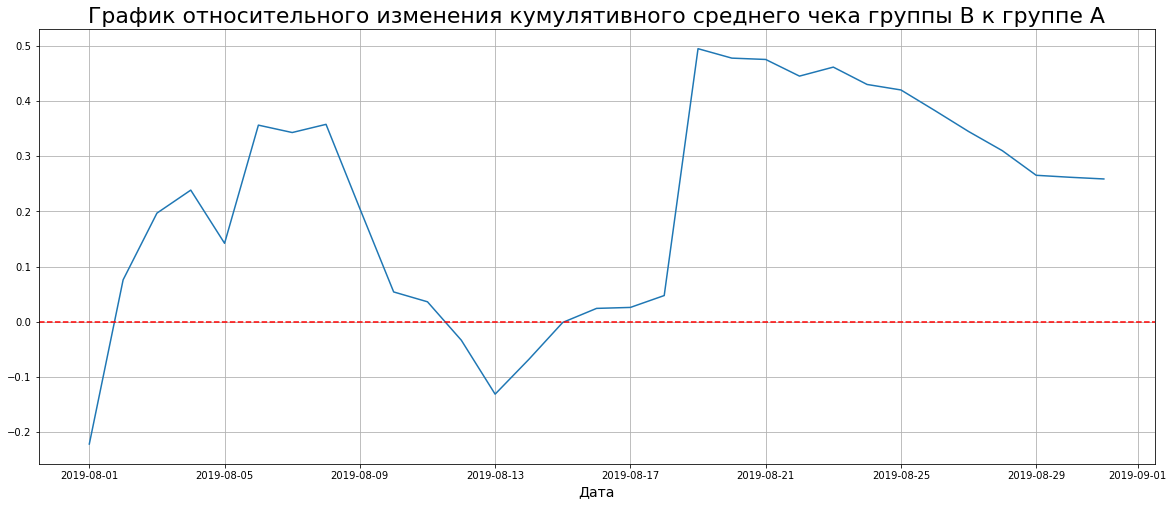

In [22]:
# Собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(20,8))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='red', linestyle='--') 
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', size=22)
plt.xlabel('Дата', size=14)
plt.grid()
plt.show()

**Вывод** График "штормит" - явно есть вляине анoмальных значений.

### График кумулятивной конверсии по группам<a id="a_b_test_4"></a>

In [23]:
# Найдём минимальную и максимальную дату, чтобы задать мастаб оси Х
print(mergedCumulativeRevenue['date'].min())
print(mergedCumulativeRevenue['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


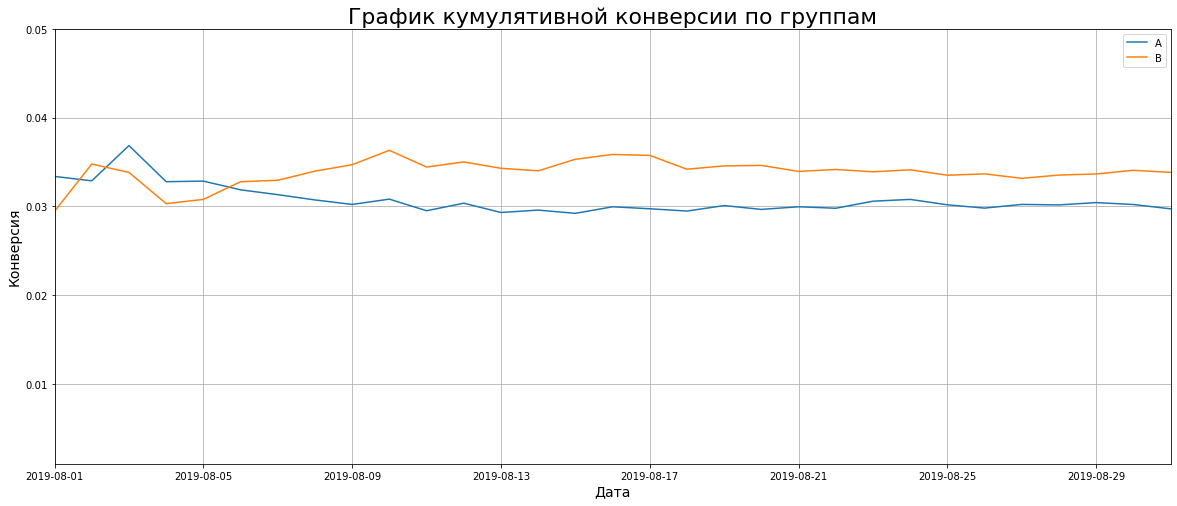

In [24]:
# Считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# Отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# Отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']


# строим графики
plt.figure(figsize=(20,8))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0.001, 0.05])
plt.title('График кумулятивной конверсии по группам', size=22)
plt.xlabel('Дата', size=14)
plt.ylabel('Конверсия', size=14)
plt.legend()
plt.grid()
plt.show()

**Вывод** До 6 августа данные колебаются вокруг одного значения. Но затем конверсия группы В вырывается в лидеры и фиксируется примерно на одном уровне. Так же по группе А - с 10 августа она зафиксировалась примерно на одном значении.

### График относительного изменения кумулятивной конверсии группы B к группе A<a id="a_b_test_5"></a>

In [25]:
# Расчитаем относительное изменение кумулятивной конверсии группы B к группе A
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on = 'date', right_on='date', how = 'left', suffixes = ['A', 'B'])

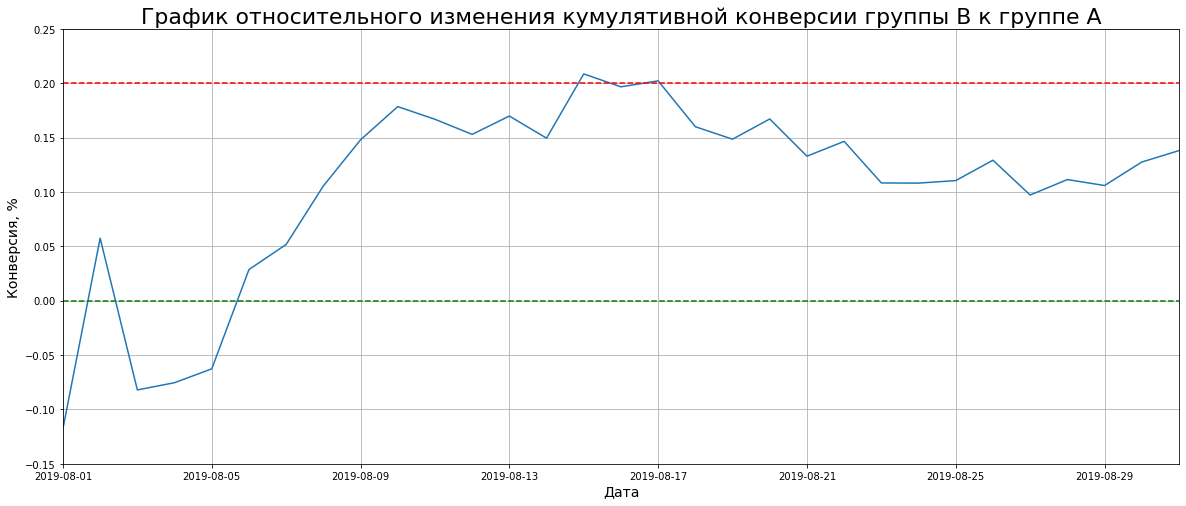

In [26]:
plt.figure(figsize=(20,8))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")


plt.axhline(y=0, color='green', linestyle='--')
plt.axhline(y=0.2, color='red', linestyle='--')

plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), -0.15, 0.25])
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', size=22)
plt.xlabel('Дата', size=14)
plt.ylabel('Конверсия, %', size=14)
plt.grid()
plt.show()

**Вывод** С самого начала эксперемента группа В лидирует в конверсии, но достигнув отметки 20% стала немного сбавлять темп и зафиксировалась в отметке примерно 12-13% относительно группы А.

### Точечный график количества заказов по пользователям<a id="a_b_test_6"></a>

Подсчитаем число заказов по пользователям — создим датафрейм c двумя столбцами: 'userId' и 'orders'. Назовиём его ordersByUsers

In [27]:
ordersByUsers  = orders.drop(['group', 'revenue', 'date'], 
                             axis=1).groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsers.columns = ['userId', 'orders']
ordersByUsers.sort_values('orders')

,userId,orders
0,5114589,1
656,2705308997,1
658,2710193528,1
659,2710478747,1
660,2710492161,1
...,...,...
897,3717692402,5
487,2038680547,8
569,2378935119,9
1023,4256040402,11


Построим гистограмму распледеления

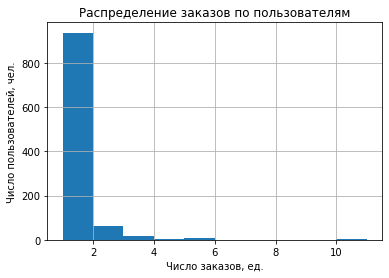

In [28]:
plt.hist(ordersByUsers['orders'])
plt.grid()
plt.title('Распределение заказов по пользователям')
plt.xlabel('Число заказов, ед.')
plt.ylabel('Число пользователей, чел.')
plt.show()

Большинство пользователей совершило всего 1 заказ.Но, сколько пользователей сделало заказы 2, 3 и более раз не ясно. Постоим точечный график


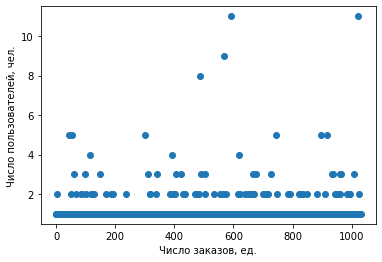

In [29]:
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.xlabel('Число заказов, ед.')
plt.ylabel('Число пользователей, чел.')
plt.show()

**Вывод** Пользователей, сделавших более 2-х заказов совсем мало - они вполне могут быть аномальными.


### 95-й и 99-й перцентили количества заказов на пользователя<a id="a_b_test_7"></a>

In [30]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

**Вывод** Не более 5% пользователей совершали более 2 заказов, и не более 1% - больше 4 заказов.

### Точечный график стоимостей заказов<a id="a_b_test_8"></a>

Построим гистограмму распределения выручки от заказов


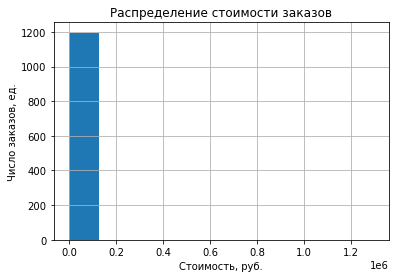

In [31]:
plt.hist(orders['revenue'])
plt.grid()
plt.title('Распределение стоимости заказов')
plt.xlabel('Стоимость, руб.')
plt.ylabel('Число заказов, ед.')
plt.show()

Сумма большинства заказов менее 20 000 рублей

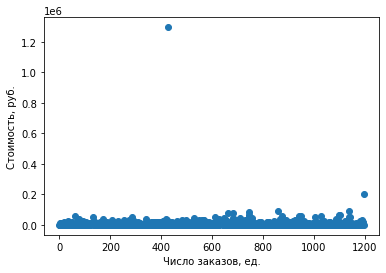

In [32]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.xlabel('Число заказов, ед.')
plt.ylabel('Стоимость, руб.')
plt.show()

Один выброс смазывает всю картину, исключим это наблюдение и постром диаграмму рассеивания с без него

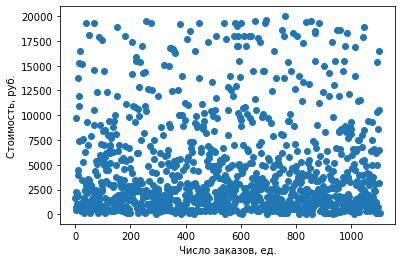

In [33]:
# Удалим заказы с суммлой больше 20000 
orders_clean = orders.query('revenue <= 20000')
x_values = pd.Series(range(0, len(orders_clean['revenue'])))
plt.scatter(x_values, orders_clean['revenue'])
plt.xlabel('Число заказов, ед.')
plt.ylabel('Стоимость, руб.')
plt.show()

**Вывод** Большинство заказов в пределах 2500 рублей.

### 95-й и 99-й перцентили стоимости заказов<a id="a_b_test_9"></a>

In [34]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

**Вывод** Не более, чем у 5% заказов чек дороже 28 000 рублей. И не больше, чем у 1% - дороже 58233 рубля

### Расчёт статистической значимости различий в конверсии между группами по «сырым» данным<a id="a_b_test_10"></a>

Определим нулевую (Н0) и альтернативную гипотезу (Н1):   
* Н0 - Конверсия группы  В равна конверсии группы А;   
* Н1 - Конверсия группы  В НЕ равна конверсии группы А.  

Зачение альфа - 5%.  

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей. Создадим датафрейм data, со следующими колонками:      
* date — дата;   
* ordersPerDateA — количество заказов в выбранную дату в группе A;   
* revenuePerDateA — суммарная выручка в выбранную дату в группе A;   
* ordersPerDateB — количество заказов в выбранную дату в группе B;   
* revenuePerDateB — суммарная выручка в выбранную дату в группе B;   
* ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;   
* revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;   
* ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;   
* revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;  
* visitorsPerDateA — количество пользователей в выбранную дату в группе A;  
* visitorsPerDateB — количество пользователей в выбранную дату в группе B;  
* visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;  
* visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

In [35]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)

ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
display(data.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [36]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

In [37]:
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

In [38]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [39]:
print('P-value:','{0:.5f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Прирост конверсии группы В к конверсии группы А:','{0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

P-value: 0.00840
Прирост конверсии группы В к конверсии группы А: 0.138


**Вывод** P-value значиительно меньше 0.05, поэтому нулевую гипотезу отвергаем.   
Анализ "сырых" данных сообщает, что в конверсии между группами есть статистически значимые различия. Отдельный прирост конверсии группы В к конверсии группы А равен 13.8% - статистически значимые различий в группах имеются.

### Расчёт статистической значимости различий в среднем чеке заказа между группами по «сырым» данным<a id="a_b_test_11"></a>

Определим нулевую (Н0) и альтернативную гипотезу (Н1):   
* H0 - Средний чек группы A равен среднему чеку группы B;   
* H1 - Средний чек группы A НЕ равен среднему чеку группы B;   

Значение альфа - 5%.   
Посчитаем статистическую значимость различия средних чеков между группами.   

In [40]:
print('P-value:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительная разница среднего чека между сегментами:','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value: 0.365
Относительная разница среднего чека между сегментами: 0.259


**Вывод** P-value больше 0.05 - статистически значимых отличий в среднем чеке между группами нету. Принимаем гипотезу.   
Разница среднего чека между сегментами высока - 25.9%. Скорее всего влитяние оказывают аномальные значений.

###  Расчёт статистической значимости различий в конверсии между группами по «очищенным» данным<a id="a_b_test_12"></a>

95 и 99 перцентили средних чеков равны 28000 и 58233 рублям.95% пользователей сделаи не более 2 заказов.   
Примем за аномальных пользователей тех, кто совершил более 2 заказа и более или совершил заказ на сумму свыше 28 000 рублей.   
Определить аномальные заказы и пользователей, совершивших их, и добавим их в список аномальных.

In [41]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']

In [42]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head())

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64


In [43]:
#Посчитаем число аномальных пользователей
print('Число пользователей с аномальными значениями - ', abnormalUsers.shape)

Число пользователей с аномальными значениями -  (74,)


**Вывод** После удаления аномальных пользователей посчитаем статистическую значимость и узнаем если ли разница до/после очищения от аномальний

Определим нулевую (Н0) и альтернативную гипотезу (Н1):   
* Н0 - Конверсия группы  В равна конверсии группы А;   
* Н1 - Конверсия группы  В НЕ равна конверсии группы А.   

Зачение альфа - 5%.  
Выясним, есть ли существенные различия конверсии между группами с очищенными данными


In [44]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [45]:
print('По очищенным данным')
print('P-value:','{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Прирост конверсии группы В к конверсии группы А:','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

По очищенным данным
P-value: 0.00652
Прирост конверсии группы В к конверсии группы А: 0.173


**Вывод** Как и в случае с сырыми данными, статистическая значимость достигнута. Сегмент В значительно лучше сегмента А. Отвергаем H0.    
После очистки данных значение p-value снизилось с 0.729 для "сырых" данных до 0.01304 для очищенных, а прирост конверии упал с 25.9% до 17.3% (на 8.6 процентных пункта)

### Расчёт статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным<a id="a_b_test_13"></a>

Определим нулевую (Н0) и альтернативную гипотезу (Н1):   
* H0 - Средний чек группы A равен среднему чеку группы B;   
* H1 - Средний чек группы A НЕ равен среднему чеку группы B;   

Значение альфа - 5%.     
Выясним, есть ли существенные различия средних чеков межу группами с очищенными данными.

In [46]:
print('По очищенным данным')
print('P-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'], 
            True, # что бы задать 4ый параметр 
            'two-sided' # для двух-стороннего теста
        )[1]
    )
)

print('Относительная разница среднего чека между сегментами:',
    '{0:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

По очищенным данным
P-value: 0.738
Относительная разница среднего чека между сегментами: -0.020


**Вывод** После очистки данных от аномалий p-value по среднему чеку не изменился - статистически значимых отличий между группами **нет**. Относительное различие группы В относительно группы А, после очистки данных составляет 2% в пользу группы А. Отвергаем Н0.

### Решение по результатам теста<a id="a_b_test_summary"></a>

**Во-первых**, статистически значимое различие по конверсии между группами **есть**, как по 'сырым' данным, так и после фильтрации аномалий.   
**Во-вторых**, статистически значимого различия по среднему чеку между группами **нет**, как по 'сырым' данным, так и после фильтрации аномалий.   
**В-третьих**, конверсия группы B лучше группы A: она имеют тенденцию к росту, и на 12-13% выше чем у группы А.    
**В-четвёртых**, после очистки данных от аномалий - конверсия гоуппы В осталась стаитстически значимой (17%). Но,  существенной разницы в размере среднего чека нет  - пользователи начали  покупать чаще, на на меньшие суммы.   

**Вывод** Тест следует остановить, зафиксировав победу группы В.

---

## Заключение<a id="summary"></a>

В рамках выполения проекта были сделаны:   
1. исследовательский анализ и предобработка данных;   
1. приоретизация гипотез - приоритет стот отдать гипотезам:   
* добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (гипотеза 7) и   
* добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (гипотеза 0)  
3. анализ А/В-теста - принято решение рекомендовать завершить тест, зафиксиоровав победу группы В.